In [29]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import ConcatDataset
from tqdm import tqdm

Below is our most successful CNN. We will describe our hyperparameter tuning in detail later.

We tried many hyperparameter adjustments, including Data Augmentation, Learning Rate, Batch Size, Number of Layers, Number of Neurons per Layer, Optimizer, and Dropout. Finally, we found a model with high accuracy through dozens of tests.

Data Augmentation
- Data augmentation was the first major adjustment we made. Due to the insufficiency of our data volume, we adopted techniques such as rotation, flipping, and scaling for data augmentation. These methods significantly increased our training data volume.

We have done a test that clearly illustrates the difference 
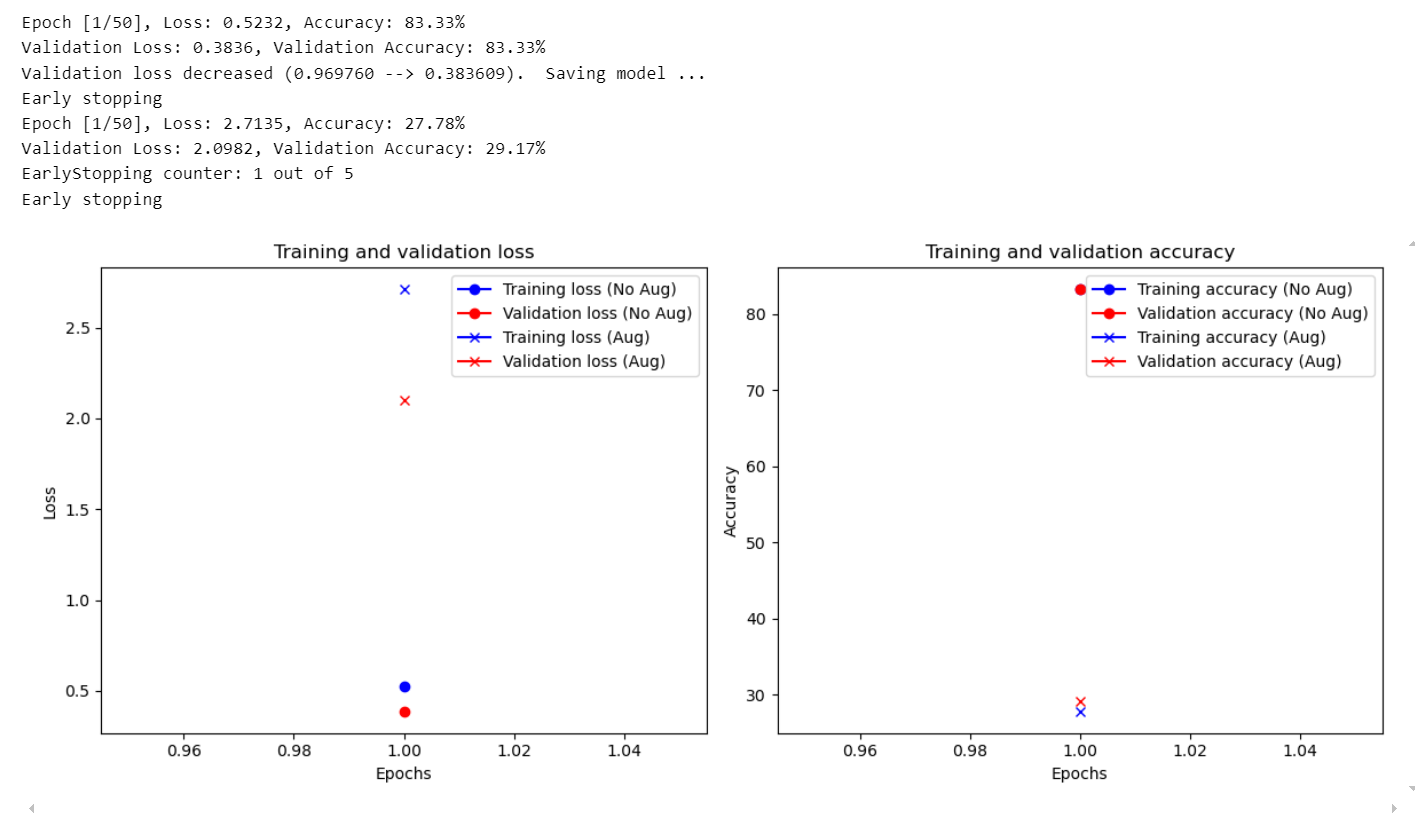



When data augmentation is not used, the model tends to overfit quickly.

In [30]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_train1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_train2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(180),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [31]:
data_path = './data1'
dataset = ImageFolder(root=data_path, transform=transform_train)
dataset1 = ImageFolder(root=data_path, transform=transform_train1)
dataset2 = ImageFolder(root=data_path, transform=transform_train2)
combined_dataset = ConcatDataset([dataset,dataset1, dataset2])

In [32]:
def check_class_distribution(dataset, name):
    class_counts = Counter([label for _, label in dataset])
    print(f"{name} class distribution: {class_counts}")
    return class_counts

We experimented with different batch sizes, including 16, 32, and 64. Smaller batch sizes provided more delicate gradient updates, while larger batch sizes accelerated the training speed. Through experiments, we increased the batch size from 8 to 32 and observed a noticeable increase in training speed, but the accuracy on the test set decreased. 

In [33]:
train_size = int(0.7 * len(combined_dataset))
val_size = int(0.2 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = transform_val_test
test_dataset.dataset.transform = transform_val_test
train_class_counts = check_class_distribution(train_dataset, "Train")
val_class_counts = check_class_distribution(val_dataset, "Validation")
test_class_counts = check_class_distribution( test_dataset, "Test")
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = dataset.classes
print(classes)

Train class distribution: Counter({4: 38, 7: 33, 2: 33, 5: 32, 1: 32, 3: 31, 0: 30, 6: 22})
Validation class distribution: Counter({6: 17, 5: 11, 7: 9, 2: 8, 0: 8, 1: 7, 3: 7, 4: 5})
Test class distribution: Counter({3: 7, 0: 7, 1: 6, 6: 6, 2: 4, 7: 3, 5: 2, 4: 2})
['amanita_gemmata', 'bronze_bolete', 'crimped_gill', 'fairy_ring_champignons', 'grey_knight', 'jelly_ears', 'lions_mane', 'panthercap']


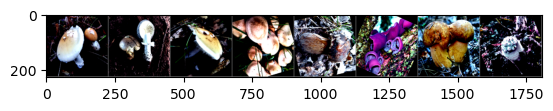

Labels:  amanita_gemmata panthercap amanita_gemmata fairy_ring_champignons bronze_bolete jelly_ears bronze_bolete panthercap


In [34]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('Labels: ', ' '.join(f'{dataset.classes[labels[j]]}' for j in range(len(images))))
class_names = dataset.classes

Regarding the number of layers, we experimented with adding more convolutional and fully connected layers. Although increasing the number of layers sometimes improves the model's expressive power, in our experiments, it did not significantly enhance model performance. 

In [35]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.6)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 32 * 56 * 56)
        x = self.dropout(F.relu(self.bn3(self.fc1(x))))
        x = self.fc2(x)
        return x

Adjusting the learning rate is a key step in optimizing model performance. We started with a relatively high initial learning rate of 0.01 and gradually decreased it to 0.0005. Through multiple trials, we found that adjusting the learning rate could significantly reduce the validation loss, from 2 down to 0.8. 

In [36]:
model = CustomCNN(len(classes))

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5) 
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print the device
print(device)
model = model.to(device)

cuda


In [37]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

early_stopping = EarlyStopping(patience=10, verbose=True)

In [38]:
def train(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs=50, save_path='model_checkpoint.pth'):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100. * correct / total)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100.*correct/total:.2f}%')

        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        scheduler.step(val_loss)

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies,
        }, save_path)

    return train_losses, val_losses, train_accuracies, val_accuracies


def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100. * correct / total

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    return val_loss, val_accuracy

In [39]:
class ImagePredictor:
    def __init__(self, model, classes, device):
        self.model = model
        self.classes = classes
        self.device = device
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict_image(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)

        self.model.eval()

        with torch.no_grad():
            outputs = self.model(image)
            _, predicted = torch.max(outputs, 1)

        predicted_class = self.classes[predicted[0]]

        img = image.cpu().squeeze().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        plt.imshow(img)
        plt.title(f'Predicted: {predicted_class}')
        plt.axis('off')
        plt.show()

        return predicted_class

    def calculate_accuracy(self, test_loader, criterion):
        self.model.eval()
        correct = 0
        total = 0
        test_loss = 0.0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        accuracy = 100 * correct / total

        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
        return test_loss, accuracy

Epoch [1/25], Loss: 1.8962, Accuracy: 24.30%
Validation Loss: 1.7744, Validation Accuracy: 33.33%
Validation loss decreased (inf --> 1.774373).  Saving model ...
Epoch [2/25], Loss: 1.4824, Accuracy: 47.41%
Validation Loss: 1.4211, Validation Accuracy: 56.94%
Validation loss decreased (1.774373 --> 1.421084).  Saving model ...
Epoch [3/25], Loss: 1.3564, Accuracy: 51.79%
Validation Loss: 1.3226, Validation Accuracy: 61.11%
Validation loss decreased (1.421084 --> 1.322600).  Saving model ...
Epoch [4/25], Loss: 1.1418, Accuracy: 67.33%
Validation Loss: 1.2583, Validation Accuracy: 59.72%
Validation loss decreased (1.322600 --> 1.258331).  Saving model ...
Epoch [5/25], Loss: 1.1956, Accuracy: 59.36%
Validation Loss: 1.2488, Validation Accuracy: 63.89%
Validation loss decreased (1.258331 --> 1.248807).  Saving model ...
Epoch [6/25], Loss: 1.0689, Accuracy: 68.53%
Validation Loss: 1.1329, Validation Accuracy: 70.83%
Validation loss decreased (1.248807 --> 1.132850).  Saving model ...
Epo

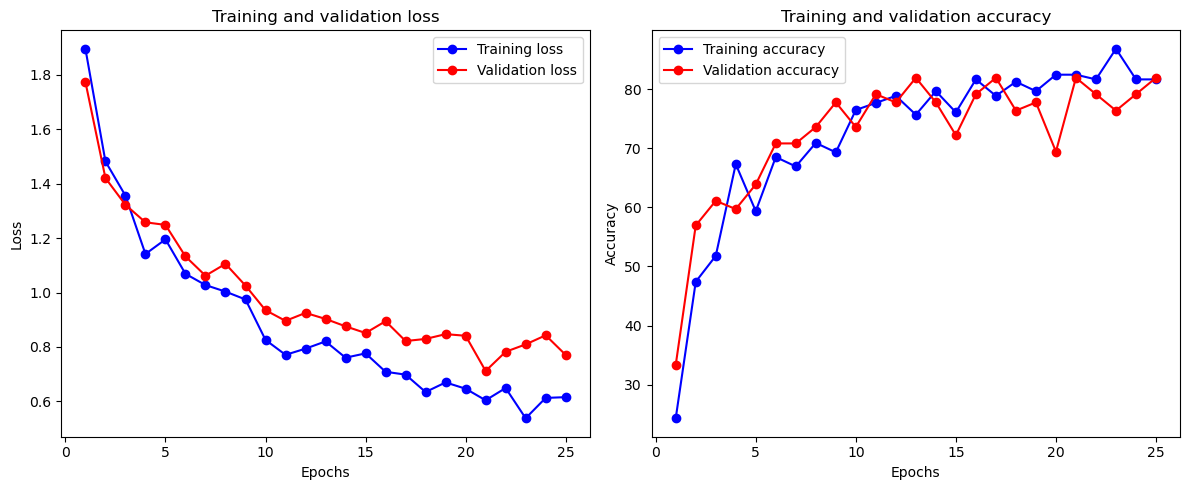

In [41]:
num_epochs = 25
train_losses, val_losses, train_accuracies, val_accuracies = train(model, criterion, optimizer, scheduler, train_loader, val_loader, device, num_epochs, save_path='model_checkpoint.pth')

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

We use this to test images outside the dataset. Based on the test results, the prediction accuracy of the model on external data is basically the same as the performance on the training and validation sets.

The model is stable when processing unseen data

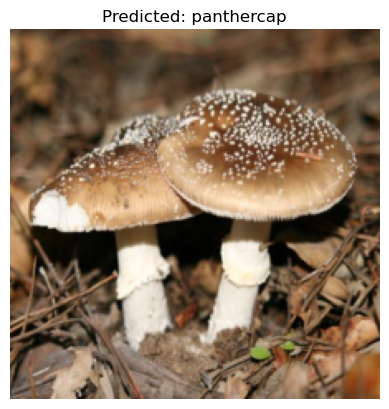

The predicted class is: panthercap - Toxic
Test Loss: 0.6792, Test Accuracy: 86.49%


In [48]:
image_path = '113.jpg' 
import PIL.Image as Image
predictor = ImagePredictor(model, classes, device)

predicted_class = predictor.predict_image(image_path)
if predicted_class in ['amanita_gemmata', 'panthercap']:
    print(f'The predicted class is: {predicted_class} - poisonous')
else:
    print(f'The predicted class is: {predicted_class} - non-poisonous')

# Calculate accuracy 
test_loss, test_accuracy = predictor.calculate_accuracy(test_loader, criterion)

The output shows that the training process is successful when testing the images in the dataset.

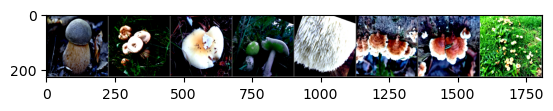

GroundTruth:  bronze_bolete fairy_ring_champignons amanita_gemmata amanita_gemmata lions_mane crimped_gill crimped_gill fairy_ring_champignons
Predicted:  bronze_bolete fairy_ring_champignons amanita_gemmata jelly_ears lions_mane crimped_gill crimped_gill fairy_ring_champignons


In [43]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(len(images))))
print('Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(len(images))))